In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [ ]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_4um_back_10M_300keV.pkl")

In [ ]:
len(df.event.unique())

# Generate random multi-electron events

In [4]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

Created dataset for events from 0 to 198917


In [5]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [42]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [16]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


In [43]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

nzeros = 0.0, ncts = 3599.999999999999, wcts = 1
m =  -2.885156250000012 b =  -17.25 Lmin= -3599.999999999999
NOTE: hard-coding m and b
nzeros = 1830.0, ncts = 3600.0, wcts = 1
m =  -1.9910156250000028 b =  89.390625 Lmin= -5430.0
NOTE: hard-coding m and b
nzeros = 1565.91417440853, ncts = 3576.91417440853, wcts = 1
m =  -1.936230468750003 b =  81.515625 Lmin= -4771.889611252
NOTE: hard-coding m and b
nzeros = 2006.244, ncts = 3599.244, wcts = 1
m =  -1.9800012588501006 b =  90.84539794921875 Lmin= -5362.9839999999995
NOTE: hard-coding m and b


Total counts, truth: 100000.0
Total counts, classical: 100000.0
Total counts, unet: 158123


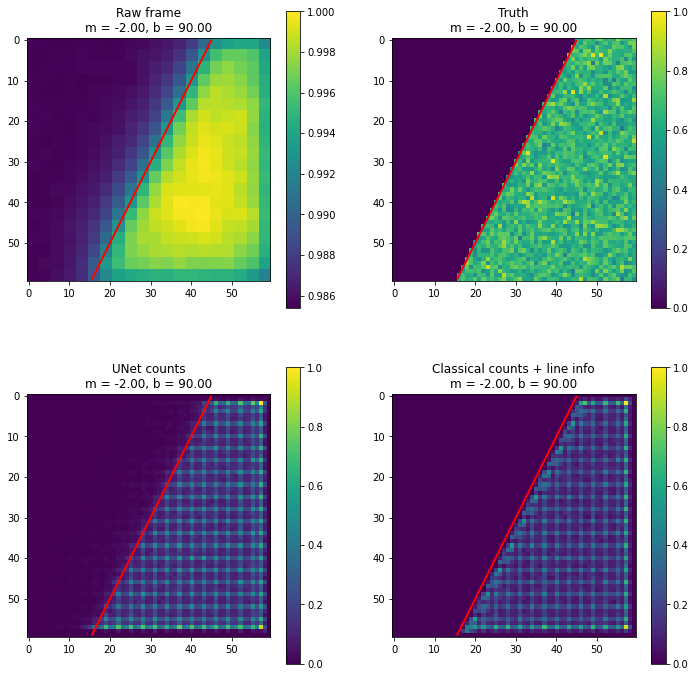

In [44]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

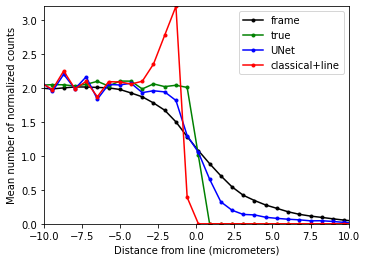

In [50]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th08_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 198917


In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_noedge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

Text(0.5, 1.0, 'Accuracy')

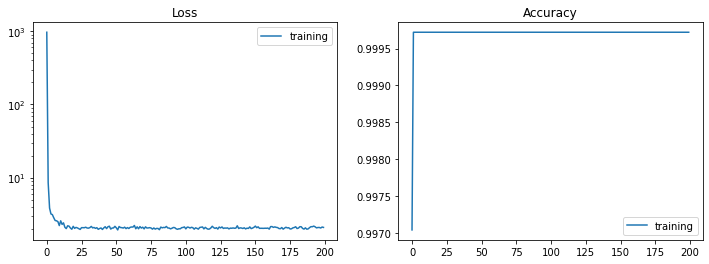

In [15]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [3]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

1/1 electrons predicted
1/1 electrons coincided exactly
3599/3599 empty spaces coincided exactly
Line drawn: m = -2.0, b = 80


Text(0.5, 1.0, '1/1 electrons predicted\n1/1 electrons coincided exactly\n3599/3599 empty spaces coincided exactly')

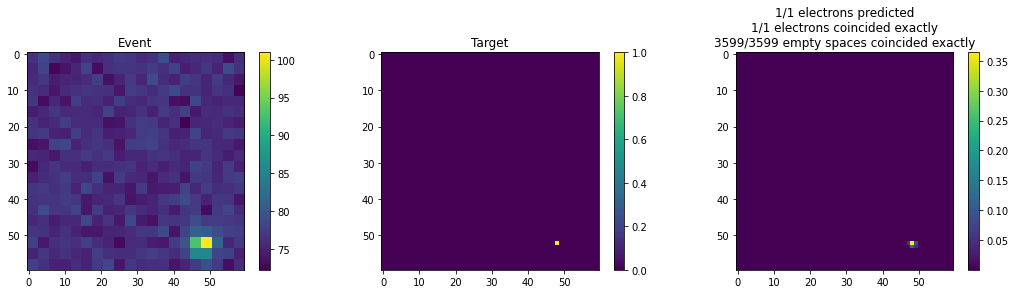

In [14]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))